In [2]:
import sys
import os

# Asegura que la raíz del proyecto esté en el path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [3]:
# 1. Cargar datos
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from src.etl import run_etl

In [4]:
# Estilo
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [12]:
# Ejecutar ETL
df = run_etl()
df['fecha_venta'] = pd.to_datetime(df['fecha_venta'])

Cargando datos de MySQL y MongoDB...
Transformando datos...
ETL completado. Dataset listo para modelado.


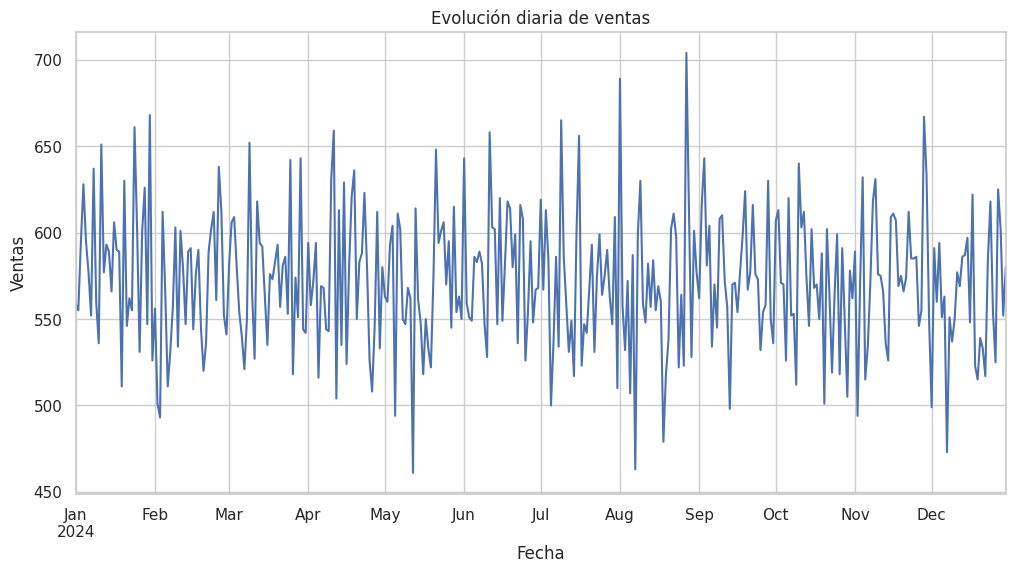

In [13]:
# --------------------------------------------
# 2. Análisis exploratorio (EDA)
# --------------------------------------------

# Ventas a lo largo del tiempo
df.groupby('fecha_venta')['ventas'].sum().plot()
plt.title("Evolución diaria de ventas")
plt.ylabel("Ventas")
plt.xlabel("Fecha")
plt.show()

## Interpretación del gráfico – Evolución diaria de ventas

El gráfico muestra la variación de las ventas totales por día a lo largo del año 2024. A partir del análisis visual se puede observar lo siguiente:

- Las ventas presentan fluctuaciones significativas entre días consecutivos. Esto puede deberse a factores como clima, tipo de día (laboral vs. festivo), promociones o hábitos de consumo.
- Aunque existen picos y valles marcados, el rango promedio de ventas se mantiene entre __500 y 650 unidades__ la mayor parte del tiempo. No hay una tendencia clara de crecimiento o caída prolongada, lo que sugiere una estacionalidad débil o estable.
- Se pueden observar algunos días con picos por encima de __680 ventas__ o caídas por debajo de __470__, lo cual puede indicar días especiales (festivos, promociones, fallos operativos, etc.). Estos puntos podrían analizarse como outliers en un análisis adicional.


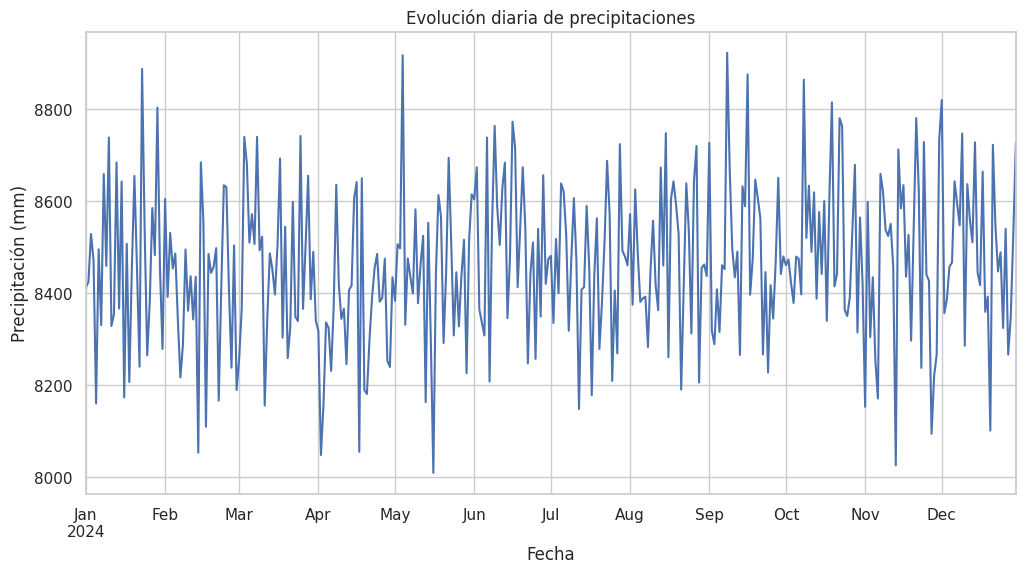

In [19]:
# Precipitaciones a lo largo del tiempo
df.groupby('fecha_venta')['precipitacion'].mean().plot()
plt.title("Evolución diaria de precipitaciones")
plt.ylabel("Precipitación (mm)")
plt.xlabel("Fecha")
plt.show()

## Interpretacion del gráfico – Evolución diaria de precipitaciones ##

Representa la variación de las precipitaciones medidas por sensores en diferentes regiones de Bogotá a lo largo del año 2024. A partir del análisis visual se destacan los siguientes puntos:

- La precipitación diaria presenta constantes cambios, con valores que oscilan principalmente entre los __8,000 y 8,900 mm__. Esto indica una alta variabilidad climática durante el año, sin una tendencia prolongada de aumento o disminución.
- Se observan picos altos de lluvia distribuidos durante todo el año, especialmente en los primeros meses __(enero-febrero)__ y hacia el final __(noviembre-diciembre)__, lo que podría corresponder a temporadas de lluvia en la ciudad.
- Aunque hay meses con mayor concentración de picos, no se identifica claramente una estacionalidad definida que se mantenga constante todos los años.


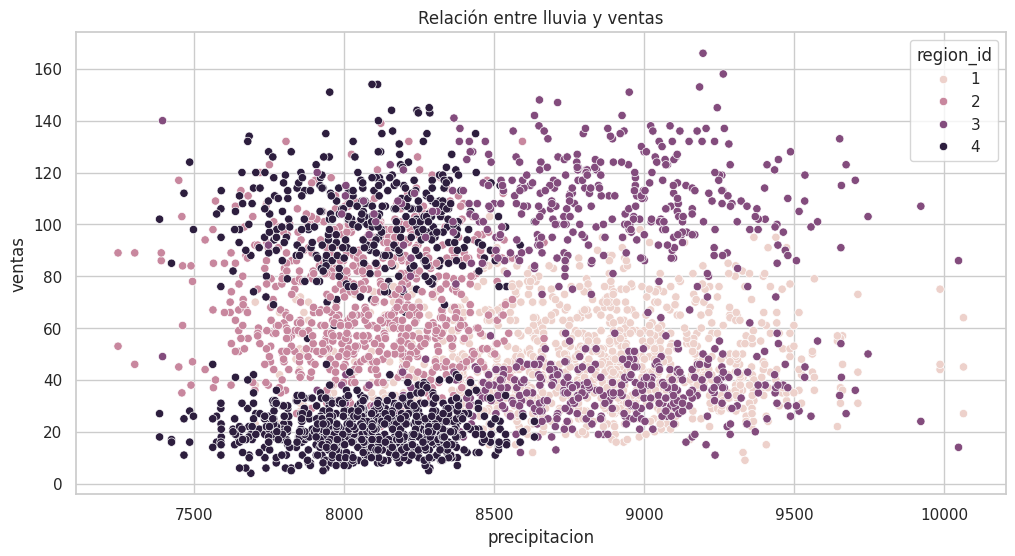

In [15]:
# Lluvia vs ventas (dispersión)
sns.scatterplot(data=df, x='precipitacion', y='ventas', hue='region_id')
plt.title("Relación entre lluvia y ventas")
plt.show()

## Interpretación del gráfico – Relación entre lluvia y ventas

Este gráfico de dispersión permite visualizar cómo se relacionan las precipitaciones (en el eje X) con el volumen de ventas (en el eje Y), clasificando los puntos según la región (region_id). A partir del análisis se pueden observar los siguientes hallazgos:

- No se evidencia una relación lineal clara entre la cantidad de lluvia y el volumen de ventas. Existen días con precipitaciones altas y ventas bajas, así como días con poca lluvia y ventas altas.
- Las regiones muestran comportamientos distintos, Algunas concentran más puntos en zonas de alta venta con baja precipitación y otras parecen operar de forma estable sin importar el nivel de lluvia. Esto justifica el uso de region_id como una variable predictiva relevante en el modelo.
- Se aprecian agrupaciones verticales por niveles de ventas (por ejemplo, en torno a 20, 60, 100), lo que podría indicar comportamientos estacionales, diferencias por tamaño de tienda o tipo de canal (virtual vs. presencial).

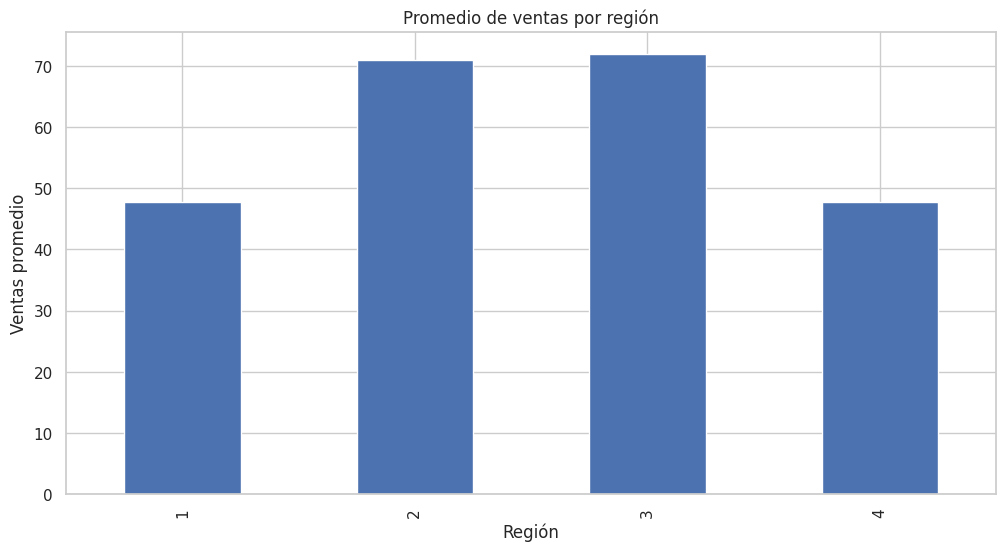

In [16]:
# Ventas promedio por región
df.groupby('region_id')['ventas'].mean().plot(kind='bar')
plt.title("Promedio de ventas por región")
plt.ylabel("Ventas promedio")
plt.xlabel("Región")
plt.show()

## Interpretación del gráfico – Promedio de ventas por región

valor promedio de ventas diarias por región, lo que permite identificar diferencias de comportamiento entre zonas geográficas.

- Las regiones 2 y 3 superan las 70 ventas promedio diarias, entonces se puede decir que concentran tiendas con mayor demanda, posiblemente por una mejor ubicación, mayor flujo de clientes o un mayor número de tiendas.
- Las regiones 1 y 4 tienen menor rendimiento, las ventas promedio cercanas a 48 unidades por día, indicando un rendimiento relativamente bajo frente a las otras regiones. Esto puede deberse a una menor densidad poblacional, menor exposición comercial o incluso impacto mayor por las lluvias.
- La diferencia entre regiones resalta la necesidad de estrategias diferenciadas, por ejemplo: campañas más agresivas en regiones con menor desempeño, o análisis adicional para entender las causas de bajo rendimiento.

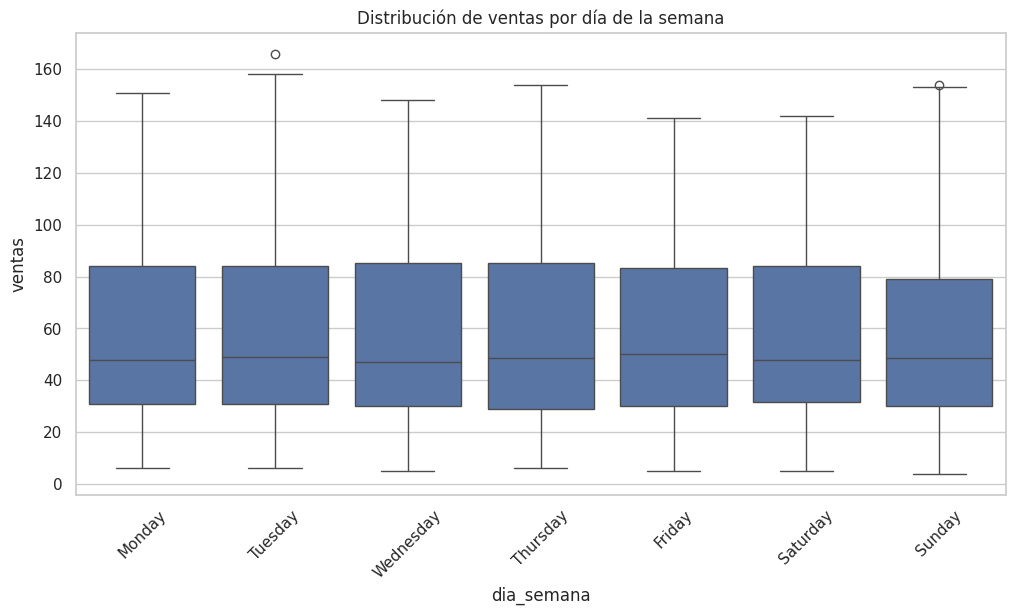

In [17]:
# --------------------------------------------
# 3. Tendencias temporales
# --------------------------------------------

# Ventas por día de la semana
df['dia_semana'] = df['fecha_venta'].dt.day_name()
sns.boxplot(data=df, x='dia_semana', y='ventas')
plt.title("Distribución de ventas por día de la semana")
plt.xticks(rotation=45)
plt.show()

## Interpretación del gráfico – Distribución de ventas por día de la semana

El boxplot permite visualizar cómo varían las ventas diarias dependiendo del día de la semana, incluyendo su dispersión, mediana y valores atípicos. A partir del análisis visual, se destacan los siguientes puntos:

- Los valores medianos de ventas se mantienen bastante estables de lunes a domingo, lo que sugiere que no hay un día claramente dominante en términos de ventas promedio.
- En todos los días hay una amplia dispersión en los valores de ventas, lo cual indica que la demanda puede fluctuar mucho dentro del mismo día de la semana, posiblemente influenciada por factores externos como el clima, ubicación o tipo de tienda.
- Se identifican varios puntos por fuera del rango normal (por ejemplo, martes y domingo), lo que podría indicar eventos especiales, promociones o comportamientos inusuales que vale la pena analizar más a fondo.
- A diferencia de lo que podría esperarse en algunos sectores de consumo, los fines de semana no muestran un incremento significativo en comparación con los días laborales, lo cual puede indicar una demanda distribuida de forma regular en esta cadena de restaurantes.

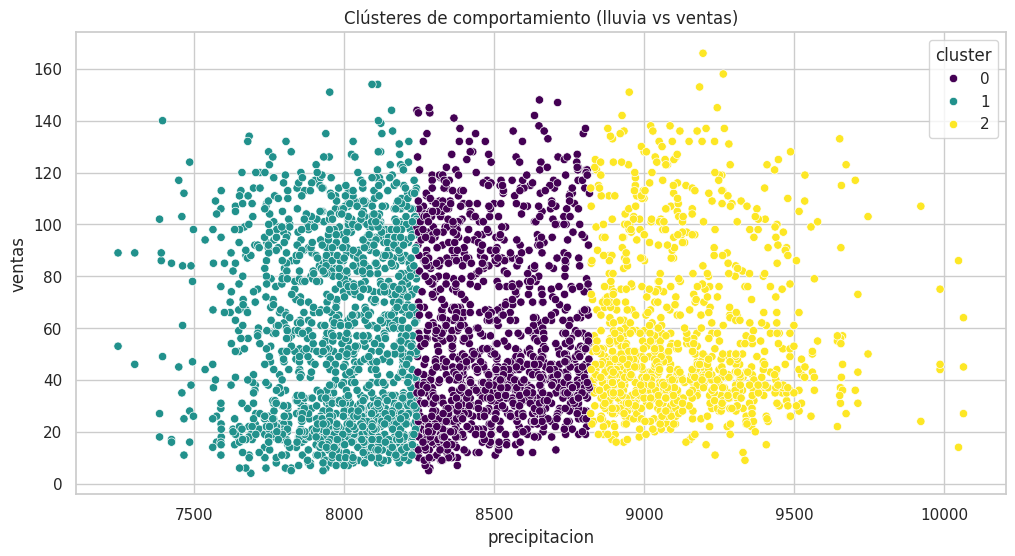

In [18]:
# --------------------------------------------
# 4. Clustering (agrupación de patrones)
# --------------------------------------------

# Selección de variables para clústeres
cluster_data = df[['ventas', 'precipitacion']]

# Modelo KMeans con 3 clústeres
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(cluster_data)

# Visualización de clústeres
sns.scatterplot(data=df, x='precipitacion', y='ventas', hue='cluster', palette='viridis')
plt.title("Clústeres de comportamiento (lluvia vs ventas)")
plt.show()

## Interpretación del gráfico – Clústeres de comportamiento (lluvia vs ventas)

El gráfico muestra el resultado de aplicar el algoritmo de agrupamiento no supervisado KMeans sobre las variables precipitacion y ventas, generando 3 clústeres que representan diferentes comportamientos observados en los datos.